<a href="https://colab.research.google.com/github/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/blob/main/Lab_1/Sesi%C3%B3n%202/Laboratorio_I_Pr%C3%A1ctica_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://bloqueneon.uniandes.edu.co/content/enforced/52233-202120_ISIS4219_01/Laboratorios.png?_&d2lSessionVal=guLBE9l4cI9Tip6PM5JSzKgp6" ><br>
# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021




## Objetivos

*   Identificar las difentes técnicas de pre-procesamiento de datos.
*   Construir Pipelines para el procesamiento y entrenamiento del modelo.
*   Visualizar un modelo construido en producción.



## Problema

Un supermercado ha decidido clasificar a sus clientes según su puntaje de consumo. Para ello, ha obtenido la información demográfica de varios de sus clientes y le ha pedido a sus expertos que clasifiquen el cliente según su historial de compras y la información recolectada. Luego de un consenso con los directivos del supermercado, se ha decidido clasificar estos clientes en tres diferentes grupos (*Low*, *Average*,  *High*). <br> <br>
Luego de etiquetar estos datos, la gerencia le ha pedido que entrene un modelo de clasificación de sus clientes nuevos, teniendo en cuenta solo la información demográfica del cliente, con el fin de poder agrupar sus clientes y enviar las promociones construidas para ellos.

### **1. Importando las librerias requeridas para el desarrollo del laboratorio**


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


In [2]:
#Data management Libraries
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport


# Data Modeling Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn_features.transformers import DataFrameSelector
from sklearn.compose import make_column_selector, ColumnTransformer


# Data visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Save the model
from joblib import dump, load

### **2. Perfilamiento y entendimiento de los datos**

#### **Lectura de los Datos**
Primero, se leen los datos y se visualizan que se hayan leido correctamente.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/main/Lab_1/Sesi%C3%B3n%202/Train.csv')

data.head()

,Unnamed: 0,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0
1,1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0
2,2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0


#### **Entendimiento de los Datos**

Luego, vamos a obtener una vista rápida de los datos, para eso utilizaremos la herramienta PandasProfiling.

In [4]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Además, Vamos a relaizar visualizaciones individuales de variables de interés.

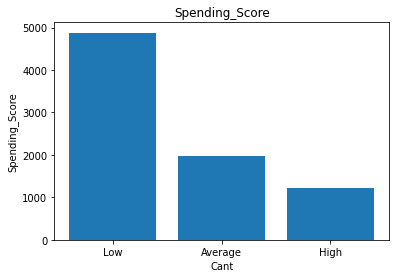

In [5]:
plt.bar(data['Spending_Score'].unique(),data['Spending_Score'].value_counts())  
plt.title('Spending_Score')  
plt.xlabel('Cant')  
plt.ylabel('Spending_Score')  
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


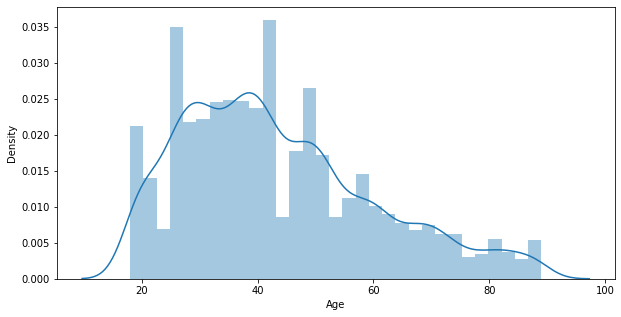

In [6]:
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.distplot(data['Age'])

### **3. Preparación de Datos**

#### **Separación de Datos**

Como se ve en Entendimeinto de los Datos, hay dos variables que realmente no nos están aportando información al problema, como lo son $Unnamed: 0$ y $ID$. <br>
Además por el contexto del problema, nuestra idea será predecir el grupo al cual pertenecerá una nueva persona.

In [7]:
X = data.drop(['Unnamed: 0','ID','Spending_Score'],axis=1)
Y = data['Spending_Score']
X.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Family_Size
0,Male,No,22,No,Healthcare,1.0,4.0
1,Female,Yes,38,Yes,Engineer,NaN,3.0
2,Female,Yes,67,Yes,Engineer,1.0,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,2.0
4,Female,Yes,40,Yes,Entertainment,NaN,6.0


Así mismo, dado que nuestro algoritmo solo entiende números, se va a transformar nuestra variable categórica a una columna de números.

In [8]:
le = LabelEncoder()

le.fit(Y)

Y = le.transform(Y)
print(le.classes_)
Y

['Average' 'High' 'Low']


array([2, 0, 2, ..., 2, 2, 0])

#### **Transformación de Datos**

Debido a que la transformación de datos puede significar la construcción de varios pasos, como el manejo de faltantes, la normalización de datos, la transformación de variables categóricas, entre otros. Se pone en práctica el uso de [Pipeline](https://scikit-learn.org/stable/modules/compose.html), el cual es una herramienta de Sklearn que nos permite unir todos estos procesos y realizar de forma automática todas las transformaciones que necesitemos.

In [9]:
estimators = [('imputer', SimpleImputer(strategy='most_frequent')), 
              ('encoder', OrdinalEncoder()),
              ]
pipe = Pipeline(estimators)
pipe

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('encoder',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>))],
         verbose=False)

In [10]:
X_mod = pipe.fit_transform(X)
data_mod = pd.DataFrame(X_mod,columns=X.columns)
data_mod.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Family_Size
0,1.0,0.0,4.0,0.0,5.0,1.0,3.0
1,0.0,1.0,18.0,1.0,2.0,1.0,2.0
2,0.0,1.0,44.0,1.0,2.0,1.0,0.0
3,1.0,1.0,44.0,1.0,7.0,0.0,1.0
4,0.0,1.0,20.0,1.0,3.0,1.0,5.0


In [11]:
estimators = [('imputer', SimpleImputer(strategy='most_frequent')), 
              ('encoder', OrdinalEncoder()),
              ('normalize',MinMaxScaler()),
              ]
pipe2 = Pipeline(estimators)
pipe2

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('encoder',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>)),
                ('normalize', MinMaxScaler(copy=True, feature_range=(0, 1)))],
         verbose=False)

In [12]:
X_mod = pipe2.fit_transform(X)
data_mod = pd.DataFrame(X_mod,columns=X.columns)
data_mod.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Family_Size
0,1.0,0.0,0.060606,0.0,0.625,0.071429,0.375
1,0.0,1.0,0.272727,1.0,0.250,0.071429,0.250
2,0.0,1.0,0.666667,1.0,0.250,0.071429,0.000
3,1.0,1.0,0.666667,1.0,0.875,0.000000,0.125
4,0.0,1.0,0.303030,1.0,0.375,0.071429,0.625




### **4. Modelamiento**

Los Pipelines no solo sirven para construir los datos, transformarlos y adaptarlos. También sirven para conectar un modelo de aprendizaje, ya sea para predecir, clasificar o estimar.

In [13]:
estimators = [('preprocessing', pipe),
              ('clf',LogisticRegression(solver='liblinear')),
              ]
model = Pipeline(estimators)
model

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='most_frequent',
                                                verbose=0)),
                                 ('encoder',
                                  OrdinalEncoder(categories='auto',
                                                 dtype=<class 'numpy.float64'>))],
                          verbose=False)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                 

In [14]:
model.fit(X,Y)

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='most_frequent',
                                                verbose=0)),
                                 ('encoder',
                                  OrdinalEncoder(categories='auto',
                                                 dtype=<class 'numpy.float64'>))],
                          verbose=False)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                 

Construimos un segundo Pipeline para poder comparar rendimientos.

In [15]:
estimators = [('preprocessing', pipe2),
              ('clf', LogisticRegression(solver='liblinear')),
              ]
model2 = Pipeline(estimators)
model2

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='most_frequent',
                                                verbose=0)),
                                 ('encoder',
                                  OrdinalEncoder(categories='auto',
                                                 dtype=<class 'numpy.float64'>)),
                                 ('normalize',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1)))],
                          verbose=False)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,

In [16]:
model2.fit(X,Y)

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='most_frequent',
                                                verbose=0)),
                                 ('encoder',
                                  OrdinalEncoder(categories='auto',
                                                 dtype=<class 'numpy.float64'>)),
                                 ('normalize',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1)))],
                          verbose=False)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,

### **5. Predicción**

#### **Predicción del clasificador**

Al igual que en la transformación de Datos, el conjunto de entrada de nuestro modelo serán los datos originales. Pero ahora al incluir un clasificador, el retornará la clase a la cual está prediciendo el dato.

In [17]:
pred1 = model.predict(X)
display(pred1)
pred2 = model2.predict(X) 
display(pred2)

array([2, 0, 2, ..., 2, 2, 0])

array([2, 0, 2, ..., 2, 2, 0])

Al obtener un modelo de clasificación y dado nuestras predicciones, podemos construir una matriz de confusión para nuestros modelos.

La documentación de la función la encuentran en la [página de Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

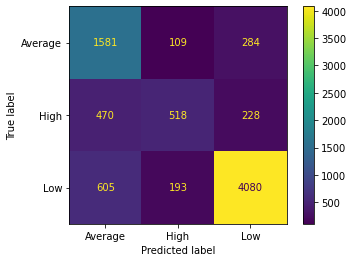

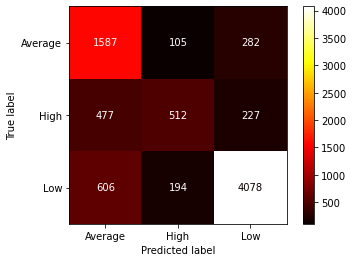

In [18]:
plot_confusion_matrix(model,X,Y,display_labels=le.classes_,values_format='d')

plot_confusion_matrix(model2,X,Y,display_labels=le.classes_,values_format='d',cmap='hot')

Y por último, para comparar nuestros modelos, utilizaremos un reporte el cual nos muestra la precisión, la cobertura, y la métrica f1 de las predicciones de ambos modelos.

In [19]:
print('----------Reporte para el Modelo 1----------')
print(classification_report(Y,pred1,target_names=le.classes_))
print('----------Reporte para el Modelo 2----------')
print(classification_report(Y,pred2,target_names=le.classes_))

----------Reporte para el Modelo 1----------
              precision    recall  f1-score   support

     Average       0.60      0.80      0.68      1974
        High       0.63      0.43      0.51      1216
         Low       0.89      0.84      0.86      4878

    accuracy                           0.77      8068
   macro avg       0.71      0.69      0.68      8068
weighted avg       0.78      0.77      0.76      8068

----------Reporte para el Modelo 2----------
              precision    recall  f1-score   support

     Average       0.59      0.80      0.68      1974
        High       0.63      0.42      0.51      1216
         Low       0.89      0.84      0.86      4878

    accuracy                           0.77      8068
   macro avg       0.70      0.69      0.68      8068
weighted avg       0.78      0.77      0.76      8068



#### **Selección de Hiperparámetros**

Otra gran ventaja de los Pipeline, es que nos permite seleccionar los hiperparámetros de construcción para obtener nuestro mejor modelo. Esta construcción la realiza a través de [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Y nos permite escoger los hiperparámetros de cada una de nuestras etapas del Pipeline. También podemos escoger si decidimos utilizar un paso o no.

In [20]:
ct = ColumnTransformer([
       ('num', SimpleImputer(strategy='mean'),
       make_column_selector(dtype_include=np.number)),
       ('cat',
       SimpleImputer(strategy='most_frequent'),
       make_column_selector(dtype_include=object))])

estimators = [('imputer', ct), 
              ('encoder', OrdinalEncoder()),
              ('normalize',MaxAbsScaler()),
              ('clf', LogisticRegression(solver='liblinear')),
              ]
pipe = Pipeline(estimators)

param_grid = dict(imputer__num__strategy=['mean', 'median'],
                  imputer__cat__strategy=['most_frequent', 'constant'],
                  encoder=[OrdinalEncoder(), OneHotEncoder()],
                  normalize=['passthrough', MaxAbsScaler()])

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=5,verbose=3,scoring='accuracy')

grid_search.fit(X,Y.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough 
[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough, score=0.758, total=   0.1s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough, score=0.747, total=   0.2s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough 
[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough, score=0.758, total=   0.1s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough, score=0.743, total=   0.2s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough 
[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough, score=0.764, total=   0.2s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=MaxAbsScaler(copy=True) 
[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=MaxAbsScaler(copy=True), score=0.758, total=   0.1s
[CV] encoder=OrdinalEncoder(categories='auto', 

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    8.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         SimpleImputer(add_indicator=False,
                                                                                       copy=True,
                                                                                       fill_value=None,
                                                                                       missing_values=nan,
                                                            

Ya que nuestro GridSearch entrenó todos los modelos, ahora podemos visualizar cuales fueron nuestros mejores hiperparámetros seleccionados, nuestro mejor modelo y una tabla de resultados de todos los modelos evaluados.

In [21]:
print(grid_search.best_params_)

{'encoder': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True), 'imputer__cat__strategy': 'most_frequent', 'imputer__num__strategy': 'mean', 'normalize': 'passthrough'}


In [22]:
resultados = pd.DataFrame(grid_search.cv_results_)
display(resultados)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_encoder,param_imputer__cat__strategy,param_imputer__num__strategy,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.141105,0.011048,0.009777,0.001631,"OrdinalEncoder(categories='auto', dtype=<class...",most_frequent,mean,passthrough,"{'encoder': OrdinalEncoder(categories='auto', ...",0.757745,0.746592,0.758364,0.743335,0.764414,0.754090,0.007875,11
1,0.102083,0.002752,0.008916,0.000521,"OrdinalEncoder(categories='auto', dtype=<class...",most_frequent,mean,MaxAbsScaler(copy=True),"{'encoder': OrdinalEncoder(categories='auto', ...",0.758364,0.747212,0.757745,0.741476,0.760694,0.753098,0.007440,12
2,0.132169,0.002656,0.008225,0.000250,"OrdinalEncoder(categories='auto', dtype=<class...",most_frequent,median,passthrough,"{'encoder': OrdinalEncoder(categories='auto', ...",0.764560,0.752788,0.766419,0.748915,0.777433,0.762023,0.010201,9
3,0.101028,0.004923,0.008846,0.001306,"OrdinalEncoder(categories='auto', dtype=<class...",most_frequent,median,MaxAbsScaler(copy=True),"{'encoder': OrdinalEncoder(categories='auto', ...",0.765799,0.752788,0.766419,0.742715,0.776813,0.760907,0.011867,10
4,0.091968,0.003071,0.009156,0.001573,"OrdinalEncoder(categories='auto', dtype=<class...",constant,mean,passthrough,"{'encoder': OrdinalEncoder(categories='auto', ...",0.744734,0.733581,0.741636,0.725976,0.748915,0.738968,0.008211,15
5,0.062138,0.004999,0.008380,0.000275,"OrdinalEncoder(categories='auto', dtype=<class...",constant,mean,MaxAbsScaler(copy=True),"{'encoder': OrdinalEncoder(categories='auto', ...",0.742255,0.732342,0.741636,0.723497,0.745195,0.736985,0.008004,16
6,0.092904,0.005844,0.008636,0.000963,"OrdinalEncoder(categories='auto', dtype=<class...",constant,median,passthrough,"{'encoder': OrdinalEncoder(categories='auto', ...",0.750929,0.732962,0.749071,0.731556,0.756355,0.744174,0.010029,13
7,0.062583,0.002813,0.008980,0.001193,"OrdinalEncoder(categories='auto', dtype=<class...",constant,median,MaxAbsScaler(copy=True),"{'encoder': OrdinalEncoder(categories='auto', ...",0.749690,0.732962,0.746592,0.727216,0.750155,0.741323,0.009431,14
8,0.107599,0.001589,0.008606,0.000125,"OneHotEncoder(categories='auto', drop=None, dt...",most_frequent,mean,passthrough,"{'encoder': OneHotEncoder(categories='auto', d...",0.802974,0.800496,0.815985,0.802232,0.819591,0.808255,0.007907,1
9,0.113266,0.003354,0.008828,0.000166,"OneHotEncoder(categories='auto', drop=None, dt...",most_frequent,mean,MaxAbsScaler(copy=True),"{'encoder': OneHotEncoder(categories='auto', d...",0.802974,0.800496,0.815985,0.802232,0.819591,0.808255,0.007907,1


Y por último, guardaremos nuestro modelo para utilizarlo después.

In [23]:
dump(grid_search.best_estimator_, 'my_model.joblib') 

model = load('my_model.joblib') 

pred1 = model.predict(X)
print('----------Reporte para el Mejor Modelo----------')
print(classification_report(Y,pred1,target_names=le.classes_))

----------Reporte para el Mejor Modelo----------
              precision    recall  f1-score   support

     Average       0.63      0.90      0.74      1974
        High       0.74      0.62      0.68      1216
         Low       0.96      0.83      0.89      4878

    accuracy                           0.82      8068
   macro avg       0.78      0.78      0.77      8068
weighted avg       0.84      0.82      0.82      8068



### **6. Validación**



Para la validación, utilizaremos un nuevo conjunto de datos que nos servirán como Conjunto Test. Como se han dado cuenta, en ningún momento le he pasado estos nuevos datos durante la etepa de entrenameinto

In [24]:
test = pd.read_csv('https://raw.githubusercontent.com/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/main/Lab_1/Sesi%C3%B3n%202/Test.csv')
X_test = test.drop(['Unnamed: 0','ID','Spending_Score'],axis=1)
Y_test = le.transform(test['Spending_Score'])

In [25]:
y_pred=model.predict(X_test)

print('----------Reporte para el Mejor Modelo con datos nuevos----------')
print(classification_report(Y_test,y_pred,target_names=le.classes_))

----------Reporte para el Mejor Modelo con datos nuevos----------
              precision    recall  f1-score   support

     Average       0.62      0.89      0.73       625
        High       0.72      0.62      0.67       386
         Low       0.95      0.83      0.88      1616

    accuracy                           0.81      2627
   macro avg       0.77      0.78      0.76      2627
weighted avg       0.84      0.81      0.82      2627



Y ahora, construiremos un dato propio para ver como se comporta nuestro modelo.

In [26]:
Gender = 'Female'
Ever_Married = 'Yes'
Age = 36
Graduated = 'Yes'
Profession = np.nan
Work_Experience = 0
Family_Size = 3
row = [Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Family_Size]

input = pd.DataFrame([row],columns=X.columns)

resp = model.predict(input)

print(model.predict_proba(input))

le.inverse_transform(resp)[0]

[[0.69784005 0.10162417 0.20053578]]


'Average'

Para desarrollar:

- Para este caso, solo se estabelcieron como hiperparámetros, el preprocesamiento de los datos, ¿Cuáles serían los hiperparámetros de la Regresión Logística? ¿Cual sería el mejor modelo que se podría construir?
- Los expertos del supermercado le han sugerido utilizar el algoritmo [KNN-Clasifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), ¿Se obtuvo un mejor modelo?
- Se dieron cuenta que sus clientes más representativos son aquellos que están clasificados en la clase 'High', por eso quieren identificar a todos sus clientes potenciales para ofrecerles descuentos. Pueden aceptar que algún cliente que no esté en esta categoría reciba la oferta, pero es importante que todos los clientes (o su gran mayoría) sea capaz de recibir esta oferta. ¿Cual sería el mejor modelo para este caso?

